In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [33]:
# !pip install lightning

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [34]:
"""
Imports
"""

import os
from dataclasses import dataclass

import lightning as L
import lightning.pytorch as pl
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from lightning.pytorch.callbacks import EarlyStopping, StochasticWeightAveraging, LearningRateMonitor, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

torch.set_float32_matmul_precision('medium')

In [35]:
@dataclass
class TrainingConfig:
    image_size = 28  # the generated image resolution

    train_batch_size = 128
    val_batch_size = 128

    max_epochs = 15
    check_val_every_n_epoch = 1
    accumulate_grad_batches = 1
    learning_rate = 1e-6

    output_dir = "lightning"

    seed = 10


config = TrainingConfig()

In [36]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((config.image_size, config.image_size)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
    T.ToPILImage(),
])

reverse_transform = T.Compose([
    # T.Resize((config.image_size, config.image_size)),
    T.ToTensor(),
    T.Normalize([-0.5/0.5], [1/0.5]),
    T.ToPILImage(),
])

In [37]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, labels: pd.DataFrame, images: pd.DataFrame, transform=None):
        super().__init__()
        self.labels = labels
        self.images = images
        assert len(self.labels) == len(self.images)
        
        self.transform = transform

    def __len__(self):
        length = len(self.labels)
        return length

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        # print(f'Reading : {image}')
        # image = torchvision.io.read_image(image)

        if self.transform:
            image = self.transform(image)

        return label, image

In [38]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(self,
                 train_transform,
                 test_transform):
        super().__init__()
        self.num_workers = os.cpu_count()  # <- use all available CPU cores

        self.train_transform = train_transform
        self.test_transform = test_transform

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup(self, stage: str):
        if stage == "fit":
            train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
            # samples = samples.sample(frac=0.4)
            train_data, val_data = train_test_split(
                train_data, 
                train_size=0.7, 
                shuffle=False)
            
            train_labels = train_data.label
            val_labels = val_data.label
            
            # Reshaping data
            train_images = train_data.iloc[:,1:].values.reshape(len(train_data), 28, 28)
            val_images = val_data.iloc[:,1:].values.reshape(len(val_data), 28, 28)
            
            train_images = torch.from_numpy(train_images).type(torch.DoubleTensor)
            val_images = torch.from_numpy(val_images).type(torch.DoubleTensor)
            
#             train_images = train_images.astype(np.float64)
#             val_images = val_images.astype(np.float64)
                              
            self.train_dataset = MNISTDataset(
                labels=train_labels,
                images=train_images,
                transform=self.train_transform
            )

            self.val_dataset = MNISTDataset(
                labels=val_labels,
                images=val_images,
                transform=self.test_transform
            )

            print(f"Total Dataset       : {len(self.train_dataset) + len(self.val_dataset)} samples")
            print(f"Train Dataset       : {len(self.train_dataset)} samples")
            print(f"Validation Dataset  : {len(self.val_dataset)} samples")
        
        if stage == 'predict':
            samples = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
            labels = samples.label
            images = samples.iloc[:,1:].values.reshape(len(samples), 28, 28)
            images = torch.from_numpy(images)
            
            self.test_dataset = MNISTDataset(
                labels=labels,
                images=images,
                transform=self.test_transform
            )
            
            print(f"Test Dataset  : {len(self.test_dataset)} samples")
            
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=config.train_batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=config.val_batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True,
            pin_memory=True,
        )

In [39]:
dm = MNISTDataModule(
    train_transform=transform,
    test_transform=transform
)

In [40]:
dm.setup(stage='fit')

Total Dataset       : 42000 samples
Train Dataset       : 29399 samples
Validation Dataset  : 12601 samples


In [49]:
label, img = dm.train_dataset[1]

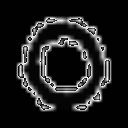

In [50]:
img

In [51]:
label

0